In [1]:
%pip install keras plotly


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install keras --upgrade


Note: you may need to restart the kernel to use updated packages.


In [3]:
from io import StringIO
from numpy import array, arange, linspace, mean, std  
from pandas import DataFrame, read_csv  
from keras.models import Sequential  
from keras.layers import Dense 
from plotly.express import scatter, bar, line  
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter, Bar  
from seaborn import heatmap, pairplot  
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import keras as keras



In [4]:
chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")

In [5]:
training_df = chicago_taxi_dataset[['TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE']]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.head(200)

Read dataset completed successfully.
Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
0,2.57,2341,31.99,Flash Cab,Mobile,6.3
1,1.18,1074,9.75,Flash Cab,Credit Card,27.9
2,1.29,1173,10.25,Sun Taxi,Cash,0.0
3,3.70,3360,23.75,Choice Taxi Association,Cash,0.0
4,1.15,1044,10.00,Flash Cab,Cash,0.0
...,...,...,...,...,...,...
195,1.13,821,9.00,Blue Ribbon Taxi Association,Mobile,22.9
196,0.57,414,6.00,Flash Cab,Cash,0.0
197,1.22,886,9.00,City Service,Cash,0.0
198,1.68,1219,9.00,Sun Taxi,Mobile,23.0


In [6]:
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
count,31694.000000,31694.000000,31694.000000,31694,31694,31694.000000
unique,NaN,NaN,NaN,31,7,NaN
top,NaN,NaN,NaN,Flash Cab,Credit Card,NaN
freq,NaN,NaN,NaN,7887,14142,NaN
mean,8.289463,1319.796397,23.905210,NaN,NaN,12.965785
std,7.265672,928.932873,16.970022,NaN,NaN,15.517765
min,0.500000,60.000000,3.250000,NaN,NaN,0.000000
25%,1.720000,548.000000,9.000000,NaN,NaN,0.000000
50%,5.920000,1081.000000,18.750000,NaN,NaN,12.200000
75%,14.500000,1888.000000,38.750000,NaN,NaN,20.800000


In [7]:

max_fare = training_df['FARE'].max()
print("What is the maximum fare? \t\t\t\tAnswer: ${fare:.2f}".format(fare = max_fare))

mean_distance = training_df['TRIP_MILES'].mean()
print("What is the mean distance across all trips? \t\tAnswer: {mean:.4f} miles".format(mean = mean_distance))

num_unique_companies =  training_df['COMPANY'].nunique()
print("How many cab companies are in the dataset? \t\tAnswer: {number}".format(number = num_unique_companies))

most_freq_payment_type = training_df['PAYMENT_TYPE'].value_counts().idxmax()
print("What is the most frequent payment type? \t\tAnswer: {type}".format(type = most_freq_payment_type))

missing_values = training_df.isnull().sum().sum()
print("Are any features missing data? \t\t\t\tAnswer:", "No" if missing_values == 0 else "Yes")


What is the maximum fare? 				Answer: $159.25
What is the mean distance across all trips? 		Answer: 8.2895 miles
How many cab companies are in the dataset? 		Answer: 31
What is the most frequent payment type? 		Answer: Credit Card
Are any features missing data? 				Answer: No


In [8]:
training_df.corr(numeric_only = True)

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
TRIP_MILES,1.000000,0.800855,0.975344,-0.049594
TRIP_SECONDS,0.800855,1.000000,0.830292,-0.084294
FARE,0.975344,0.830292,1.000000,-0.070979
TIP_RATE,-0.049594,-0.084294,-0.070979,1.000000


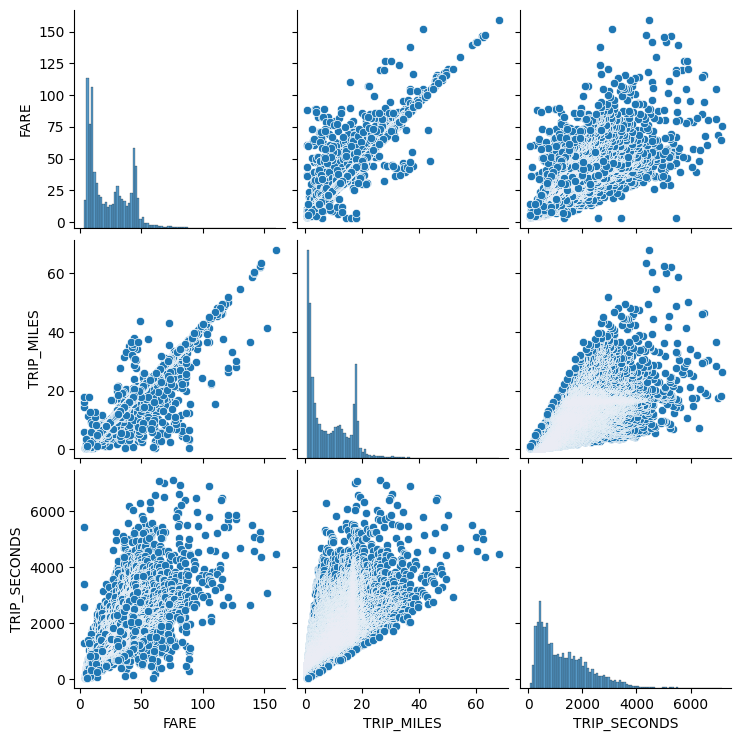

In [9]:
sns.pairplot(training_df, x_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"], y_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"])

In [10]:
def make_plots(df, feature_names, label_name, model_output, sample_size=200):

  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, rmse = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, rmse, fig)

  fig.show()
  return

def plot_loss_curve(epochs, rmse, fig):
  curve = px.line(x=epochs, y=rmse)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

def plot_model(df, features, weights, bias, fig):
  df['FARE_PREDICTED'] = bias[0]

  for index, feature in enumerate(features):
    df['FARE_PREDICTED'] = df['FARE_PREDICTED'] + weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='FARE_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "FARE_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)

  return

def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.


In [ ]:
def build_model(my_learning_rate, num_features):
 
  inputs = keras.Input(shape=(num_features,))
  outputs = keras.layers.Dense(units=1)(inputs)
  model = keras.Model(inputs=inputs, outputs=outputs)


  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, features, label, epochs, batch_size):



  history = model.fit(x=features,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)


  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]


  epochs = history.epoch
  hist = pd.DataFrame(history.history) 

  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse


def run_experiment(df, feature_names, label_name, learning_rate, epochs, batch_size):

  print('INFO: starting training experiment with features={} and label={}\n'.format(feature_names, label_name))

  num_features = len(feature_names)
 
  features = df.loc[:, feature_names].values
  label = df[label_name].values

  model = build_model(learning_rate, num_features)
  model_output = train_model(model, features, label, epochs, batch_size)

  print('\nSUCCESS: training experiment complete\n')
  print('{}'.format(model_info(feature_names, label_name, model_output)))
  make_plots(df, feature_names, label_name, model_output)

  return model

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.
